v2. This time output center point of ROI instead of upper left corner.

v3. Center x, y, w and h values around mean

v4. Don't center around mean, but center each ROI in the middle of it's cell by default. Use mean h and w as defaults.

v5. Normalize x, y to offset within grid cell, w, h to percentage of overall image size

v6. Setting values that had been 0 to some very small number to avoid sending params to inf or -inf. For a 4x4 grid there are a few cells which would contain more than one ROI. Rather than overwriting the previous one we combine the two into one larger ROI.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import csv
import pickle
import os
import pydicom
%matplotlib inline

In [2]:
GRID_SIZE = 4
location_data = np.zeros((GRID_SIZE,GRID_SIZE,5))

for i in range(4):
    for j in range(4):
        location_data[i,j,:] = [0, 390, 365, 225, 335]

In [3]:
img = pydicom.dcmread(os.path.join("stage_1_train_images", "0ab261f9-4eb5-42ab-a9a5-e918904d6356.dcm")).pixel_array

Below is an image which two ROIs in the same cell. The red boxes are the original ROIs, the blue is the new combined ROI.

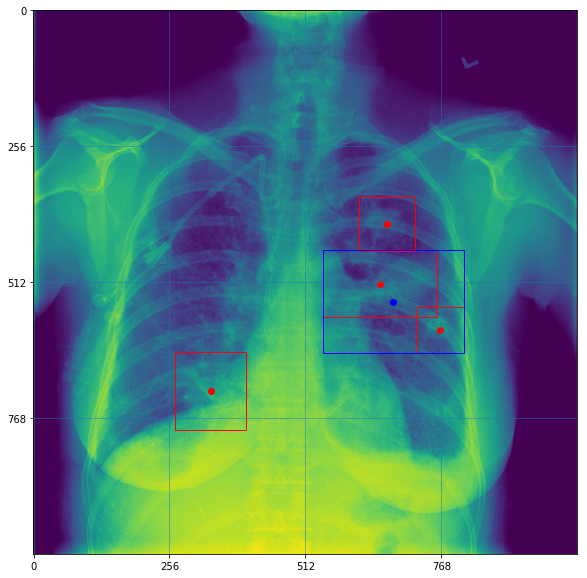

In [4]:
coords = np.arange(0, 1024, 256)

locs = [
    [613,352,106,102],
    [266,644,135,146],
    [545,452,215,125],
    [722,558,88,88]
]


fig,ax = plt.subplots(1, figsize=(10,10))
plt.imshow(img)

for loc in locs:
    x,y,w,h = loc
    center_x = x + (w / 2)
    center_y = y + (h / 2)
    
    rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    plt.plot(center_x, center_y, marker="o", color="r")
    ax.add_patch(rect_1)

rect_1 = patches.Rectangle((545,452),265,194,linewidth=1,edgecolor='b',facecolor='none')
plt.plot((545 + (265/2)), (452 + (194/2)), marker="o", color="b")
ax.add_patch(rect_1)    
    
plt.xticks(coords)
plt.yticks(coords)
for item in coords:
    plt.axvline(item, linewidth=0.5)
    plt.axhline(item, linewidth=0.5)
# plt.xlim(0,1024)
# plt.ylim(0,1024)
plt.show()

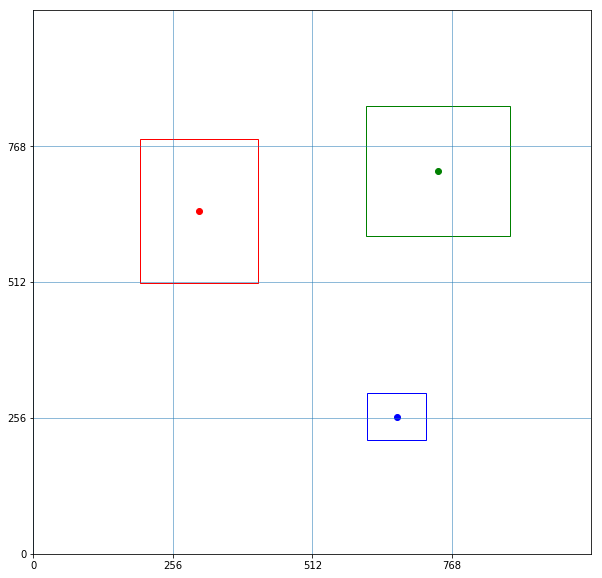

In [5]:
coords = np.arange(0, 1024, 256)

fig,ax = plt.subplots(1, figsize=(10,10))

rect_1 = patches.Rectangle((195,511),218,271,linewidth=1,edgecolor='r',facecolor='none')
plt.plot(304, 646.5, marker="o", color="r")
rect_2 = patches.Rectangle((612,214),109,89,linewidth=1,edgecolor='b',facecolor='none')
plt.plot(666.5, 258.5, marker="o", color="b")
rect_3 = patches.Rectangle((610,599),265,245,linewidth=1,edgecolor='g',facecolor='none')
plt.plot(742.5, 721.5, marker="o", color="g")
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
plt.xticks(coords)
plt.yticks(coords)
for item in coords:
    plt.axvline(item, linewidth=0.5)
    plt.axhline(item, linewidth=0.5)
plt.xlim(0,1024)
plt.ylim(0,1024)
plt.show()

In [6]:
boxes = [
    [195,511,218,271],
    [612,214,109,89],
    [610,599,265,245]
]

centers = []

for box in boxes:
    x,y,w,h = box
    center_x = x + (w / 2)
    center_y = y + (h / 2)
    centers.append((center_x,center_y))

pixel_locs = []    
for center in centers:
    x_pixel = center[0] // 64
    y_pixel = center[1] // 64
    
    pixel_locs.append((x_pixel,y_pixel))
    
pixel_locs    

[(4.0, 10.0), (10.0, 4.0), (11.0, 11.0)]

In [7]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [4]:
# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx)
    return x

In [6]:
GRID_SIZE = 4
CELL_WIDTH = 1024 // GRID_SIZE

# means to center data
mu_x = 391.456158
mu_y = 363.1358768
mu_w = 220.8453815
mu_h = 334.1743641
mu_center_x = 501.8788487
mu_center_y = 530.2230589


# empty dictionary
pneumonia_locations = {}
used_filenames = []
pixel_means = []
locations = []

# load table
with open(os.path.join('./stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        
        # initialize our data
        if filename not in used_filenames:
            location_data = np.zeros((GRID_SIZE,GRID_SIZE,5))
            
            # default label to mean values
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    y = ((i + 0.5) * CELL_WIDTH)
                    x = ((j + 0.5) * CELL_WIDTH)
                    location_data[i,j,:] = [1e-16, 0.5, 0.5, 0.001, 0.001]
                    
            used_filenames.append(filename)
            locs = np.zeros((GRID_SIZE, GRID_SIZE))
        else:
            location_data = pneumonia_locations[filename]
            
        # if row contains pneumonia add label to dictionary
        # the dictionary will contain the presence, x, y, h, w of the pneumonia for each pixel in a 16x16 grid
        if pneumonia == '1':
            # extract the location and cast them to floats
            x,y,w,h = location
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)
            
            # figure out the center of the ROI
            center_x = x + (w / 2)
            center_y = y + (h / 2)
            
            # figure out which pixel is in the center
            x_pixel = int(center_x // (1024 // GRID_SIZE))
            y_pixel = int(center_y // (1024 // GRID_SIZE))
            locs[y_pixel, x_pixel] = 1
            
            # special cases
#             if filename in ["cb4a1fca-136c-4577-bcef-d934c9f14f2c"]:
# #                 print(filename, x_pixel, y_pixel, x, y)
#                 if x == 373:
#                     x_pixel = 0
            
            ## normalize the data
            # h, w divided by overall image size
            w = w / 1024
            h = h / 1024
            
            # x, y to difference from upper left corner / cell size
            center_x = (center_x - (CELL_WIDTH * x_pixel)) / CELL_WIDTH
            center_y = (center_y - (CELL_WIDTH * y_pixel)) / CELL_WIDTH
            
            # if more than one ROI exists in the same box, expand the ROI to include the new one
            if location_data[y_pixel,x_pixel,0] == 1:
                # get the old location
                old_center_x, old_center_y, old_w, old_h = location_data[y_pixel, x_pixel, 1:]
                
                # unnormalize the old loc data
                old_w, old_h = old_w * 1024, old_h * 1024
                old_center_x = unnorm(old_center_x, x_pixel, CELL_WIDTH)
                old_center_y = unnorm(old_center_y, y_pixel, CELL_WIDTH)
                
                # convert to corners
                old_upper_corner_x = old_center_x - (old_w / 2)
                old_upper_corner_y = old_center_y - (old_h / 2)
                
                old_lower_corner_x = old_center_x + (old_w / 2)
                old_lower_corner_y = old_center_y + (old_h / 2)
                
#                 print("Old ROI:", old_upper_corner_x, old_upper_corner_y, old_w, old_h)
                
                # unnormalize the new data
                w = w * 1024
                h = h * 1024
                
#                 print("New ROI:", x, y, w, h)
                
                # new lower corner
                new_lower_corner_x = x + w
                new_lower_corner_y = y + h
                
#                 print("New Lower Corner:", new_lower_corner_x, new_lower_corner_y)
                
                # pick the furthest corner
                new_upper_corner_x = np.minimum(old_upper_corner_x, x)
                new_upper_corner_y = np.minimum(old_upper_corner_y, y)
                
                new_lower_corner_x = np.maximum(old_lower_corner_x, new_lower_corner_x)
                new_lower_corner_y = np.maximum(old_lower_corner_y, new_lower_corner_y)
                
                # get the new height and width
                new_w = new_lower_corner_x - new_upper_corner_x
                new_h = new_lower_corner_y - new_upper_corner_y
                
                # get the new center
                new_center_x = new_upper_corner_x + (new_w / 2)
                new_center_y = new_upper_corner_y + (new_h / 2)
                
#                 print("Combined ROI:", new_upper_corner_x, new_upper_corner_y, new_w, new_h)
                
                # normalize the new center
                new_center_x = (new_center_x - (CELL_WIDTH * x_pixel)) / CELL_WIDTH
                new_center_y = (new_center_y - (CELL_WIDTH * y_pixel)) / CELL_WIDTH
                
                # renormalize the new height and width
                new_w = new_w / 1024
                new_h = new_h / 1024
                
#                 print("New Label:", new_center_x, new_center_y, new_w, new_h)
                
                center_x = new_center_x
                center_y = new_center_y
                w = new_w
                h = new_h
                
            # write the data to our list
            location_data[y_pixel,x_pixel,0] = 1
            location_data[y_pixel,x_pixel,1] = center_x
            location_data[y_pixel,x_pixel,2] = center_y
            location_data[y_pixel,x_pixel,3] = w
            location_data[y_pixel,x_pixel,4] = h
            
            if w > 0.6:
#                 print(filename,"width", w)
                pass
            if h > 0.6:
                print(filename,"height", h)
#                 pass
        else:
            pass
        
        locations.append(location_data[:,:,1:])
        pixel_means.append(np.mean(locs))
        pneumonia_locations[filename] = location_data

03cd7a5b-d5d7-40a1-81b1-c4264920530a height 0.7314453125
05d3817a-5535-4e77-8dda-d4412e496c81 height 0.666015625
05d3817a-5535-4e77-8dda-d4412e496c81 height 0.7412109375
05d4d725-02a2-4c90-8ef8-463217889ba8 height 0.6591796875
05d4d725-02a2-4c90-8ef8-463217889ba8 height 0.6982421875
05fe7d73-5c8c-4349-88c4-2071a00d6d81 height 0.6298828125
06089341-a69b-4777-817b-041be894b436 height 0.71875
06089341-a69b-4777-817b-041be894b436 height 0.705078125
061664a4-6a23-4cb2-a0da-0c5712b6e0a6 height 0.609375
061b44ff-fd22-473d-853f-81da70e14a63 height 0.60546875
061d0ff4-a611-42ce-b780-1d1eb55e50ab height 0.6865234375
061d0ff4-a611-42ce-b780-1d1eb55e50ab height 0.7041015625
0637b804-e693-48d1-8716-f7c63ce6162a height 0.7890625
0638709c-d31d-4a59-a9e4-fc408ae36145 height 0.615234375
06420c87-02ee-4315-aa3a-63e911174435 height 0.658203125
06697be9-b1ab-444c-af0d-fd11a053f2b3 height 0.60546875
06a4f477-34ca-4625-945b-81bfa9e77273 height 0.6044921875
06ac3c8c-cd1f-4e10-ac24-4cb4f3ab1243 height 0.65136

40dbceff-201d-4889-9aa1-2064246fb6b8 height 0.6171875
4b6f8c4f-f093-4b85-a22f-4e5da0be7eeb height 0.607421875
4e90e80e-e990-4f27-8bc6-c6c11e822974 height 0.6572265625
52ba9595-c55a-43d5-88f2-6ae572263e49 height 0.615234375
6ed32587-0518-4b4b-95e6-a4b0651b1a6d height 0.6552734375
6ed32587-0518-4b4b-95e6-a4b0651b1a6d height 0.6318359375
6f3edd10-1cc0-4f2b-874f-3d599bdf463f height 0.60546875
702dd374-879d-4b8e-ad5b-7729f16a9ae2 height 0.6484375
703bcb21-559a-4c64-9d9b-6ff164c06218 height 0.63671875
805f684c-7781-45ba-83db-4ae332bd2cd7 height 0.6572265625
813e0822-259c-4c62-81bb-86b6c0a2a948 height 0.6279296875
81da1196-4ca8-4c29-b0cf-6c6cf6386a6f height 0.6396484375
81f89fe4-78c8-409b-8f4e-e20588818fa1 height 0.7001953125
82054420-6a12-4690-ae52-9d3be158499c height 0.7373046875
82054420-6a12-4690-ae52-9d3be158499c height 0.611328125
822ac3a2-71b5-4540-9139-2dcca518f09f height 0.751953125
8295ec58-4848-4e22-9b39-129e0888f413 height 0.70703125
8295ec58-4848-4e22-9b39-129e0888f413 height 0.7

a887251c-8046-4ff2-b5e5-9ef155ef94a7 height 0.611328125
a9bf1010-e610-4b41-814d-99a4250d00c3 height 0.6298828125
aa47c55a-7cf7-4105-9132-de080664f052 height 0.7841796875
aa636938-1fb2-4d4c-9678-b703388552e7 height 0.7080078125
aa636938-1fb2-4d4c-9678-b703388552e7 height 0.6884765625
aa85ecc1-f7ae-4a76-ad20-aa660f99c186 height 0.685546875
aa9ee7e3-71ef-48e3-9eac-46955dca641b height 0.6025390625
aac5e3c9-f621-4193-8818-ca6ca3ba8320 height 0.7216796875
aac5e3c9-f621-4193-8818-ca6ca3ba8320 height 0.64453125
aaf271c4-df7a-477f-a609-4dca15b54649 height 0.611328125
aafecca2-fefc-48e6-be48-a34488e06cbb height 0.6162109375
aafecca2-fefc-48e6-be48-a34488e06cbb height 0.623046875
ab150245-a188-4c66-9b84-e7dbf1f1c6cd height 0.6279296875
ab59e6e8-22f2-43f0-8fbc-3e8bcaba1d47 height 0.6123046875
abda22a1-7761-4590-a1a8-132e093c54f2 height 0.697265625
ac1c77f9-db17-4bb4-886f-718a265eaa4d height 0.7646484375
ac2257b8-e600-42bd-ab9c-951fa49b3ec6 height 0.6025390625
ac2257b8-e600-42bd-ab9c-951fa49b3ec6 h

In [7]:
# save our dict to disk
with open('yolo_labels_centered_4x4_6.p', 'wb') as handle:
    pickle.dump(pneumonia_locations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
with open('yolo_labels_centered_4x4_6.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

In [11]:
foo = pneumonia_locations["fffb2395-8edd-4954-8a89-ffe2fd329be3"]

In [12]:
foo

array([[[1.00000000e-06, 5.00000000e-01, 5.00000000e-01, 1.00000000e-03,
         1.00000000e-03],
        [1.00000000e-06, 5.00000000e-01, 5.00000000e-01, 1.00000000e-03,
         1.00000000e-03],
        [1.00000000e-06, 5.00000000e-01, 5.00000000e-01, 1.00000000e-03,
         1.00000000e-03],
        [1.00000000e-06, 5.00000000e-01, 5.00000000e-01, 1.00000000e-03,
         1.00000000e-03]],

       [[1.00000000e-06, 5.00000000e-01, 5.00000000e-01, 1.00000000e-03,
         1.00000000e-03],
        [1.00000000e-06, 5.00000000e-01, 5.00000000e-01, 1.00000000e-03,
         1.00000000e-03],
        [1.00000000e-06, 5.00000000e-01, 5.00000000e-01, 1.00000000e-03,
         1.00000000e-03],
        [1.00000000e-06, 5.00000000e-01, 5.00000000e-01, 1.00000000e-03,
         1.00000000e-03]],

       [[1.00000000e-06, 5.00000000e-01, 5.00000000e-01, 1.00000000e-03,
         1.00000000e-03],
        [1.00000000e+00, 1.30859375e-01, 1.46484375e-01, 2.19726562e-01,
         5.16601562e-01],
      

In [9]:
bar = np.array([[1, .15, .25, .1, .15], [0, .5, .5, 0, 0]])

In [11]:
print("1:3", bar[:,1:3])
print("3:", bar[:,3:])

1:3 [[0.15 0.25]
 [0.5  0.5 ]]
3: [[0.1  0.15]
 [0.   0.  ]]


In [38]:
c, x, y, w, h = foo[2,1,:]

In [39]:
(x * 256) + (256 * 1)

289.5

In [40]:
(y * 256) + (256 * 2)

549.5